In [5]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
from my_tools import get_bill_data, process_corpus, read_jsonl_file
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix

from sklearn.externals import joblib

In [1]:
print('-------------------')
print('Loading data for vectorizing and modeling...')
data, in_progress = get_bill_data()

corpus_with_labels = read_jsonl_file('/home/ubuntu/galvanize_capstone/data/nlp/corpus_with_labels.jsonl')
corpus_df = pd.DataFrame(list(corpus_with_labels))

X = corpus_df['document']
y = corpus_df['label'].astype(int)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


------------------
------------------
Data includes bills, joints resolutions, and laws with text from the 110th Congress (2007) to present
Make changes in my_tools.get_bill_data to modify the data set.
------------------


In [2]:
# create stratified train-test split
print('-------------------')
print('Performing train-test split...')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)#, random_state = 123)

# vectorizing 6M of ~30M dimensions with n-grams, l1 norm (simple avg, l2 avg**2
# use_idf=True gives more weight to words, n_grams that appear less frequently in the corpus
# sublinear_tf=True reduces the bias of length
print('-------------------')
print('Vectorizing...')
tfvect = TfidfVectorizer(ngram_range=(1, 4), 
                         max_features = 6000000,
                         norm = 'l2',              #default value
                         use_idf = True,           #default value
                         sublinear_tf = True)

X_train_vec = tfvect.fit_transform(X_train)
X_test_vec = tfvect.transform(X_test)

print('-------------------')
print('Creating vocabulary...')
vocab = tfvect.vocabulary_

-------------------
Performing train-test split...
-------------------
Vectorizing...
-------------------
Creating vocabulary...


In [6]:
# dump the TfidfVectorizer
print('-------------------')
print('Pickling the TfidfVectorizer...')
pickle_path = 'pickle_files/tfidfVectorizer.pkl'
if os.path.exists(pickle_path):
    os.remove(pickle_path)
joblib.dump(tfvect, pickle_path)
print('Pickling complete.')

-------------------
Pickling the TfidfVectorizer...
Pickling complete.


In [ ]:
# # load the TfidfVectorizer
# print('-------------------')
# print('Loading the pickled TfidfVectorizer...')
# pickle_path = 'pickle_files/tfidfVectorizer.pkl'
# tfvect = joblib.load(tfvect, pickle_path)
# print('Pickled vectorizer loaded.')

In [11]:
X_train_vec.shape

(47486, 6000000)

In [26]:
print('-------------------')
print('Training Gradient Boosting Classifier with vectorized results...')
gb = GradientBoostingClassifier(loss= 'deviance', 
                                max_features = 1000000, 
                                learning_rate = .1, 
                                n_estimators = 100, 
                                criterion = 'friedman_mse', 
                                min_samples_split = 2, 
                                min_samples_leaf = 15, 
                                max_depth = 3, 
                                max_leaf_nodes = None)

gb.fit(X_train_vec, y_train)

print('-------------------')
print('Getting predictions...')
gb_y_pred = gb.predict(X_test_vec)
gb_y_pred_proba = gb.predict_proba(X_test_vec)

print('-------------------')
print('F1 Score:\t\t{:.4f}'.format(f1_score(y_test, gb_y_pred)))
print('Recall Score:\t\t{:.4f}'.format(recall_score(y_test, gb_y_pred)))
print('Precision Score:\t{:.4f}'.format(precision_score(y_test, gb_y_pred)))
print('Accuracy Score:\t\t{:.4f}'.format(accuracy_score(y_test, gb_y_pred)))

-------------------
Training Gradient Boosting Classifier with vectorized results...
-------------------
Getting predictions...
-------------------
F1 Score:		0.9935
Recall Score:		0.9963
Precision Score:	0.9908
Accuracy Score:		0.9996


In [55]:
# dump the Gradient Boosting Model
print('-------------------')
print('Pickling the Gradient Boosting Model...')
pickle_path = 'pickle_files/nlp_gradientBoost.pkl'
if os.path.exists(pickle_path):
    os.remove(pickle_path)
joblib.dump(gb, pickle_path)
print('Pickling complete.')

-------------------
Pickling the Gradient Boosting Model...
Pickling complete.


In [32]:
confusion_matrix(y_test, gb_y_pred)

array([[15283,     5],
       [    2,   539]])

In [34]:
y_test[:3]

63193    0
13511    0
27880    0
Name: label, dtype: int64

In [36]:
gb_y_pred[:3]

array([0, 0, 0])

In [45]:
diffs = y_test - gb_y_pred

In [47]:
fp_index_list = []
fn_index_list = []

for i, j in enumerate(diffs):
    if j == 1:
        print('Index {} is a False Negative'.format(i))
        fn_index_list.append(i)
    if j == -1:
        print('Index {} is a False Positive'.format(i))
        fp_index_list.append(i)


Index 278 is a False Positive
Index 754 is a False Positive
Index 2509 is a False Negative
Index 4329 is a False Positive
Index 6672 is a False Positive
Index 9723 is a False Positive
Index 15073 is a False Negative


In [48]:
fp_index_list

[278, 754, 4329, 6672, 9723]

In [77]:
gb_y_pred_proba[:,0].max()

0.9999776145858235

(array([1.5283e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

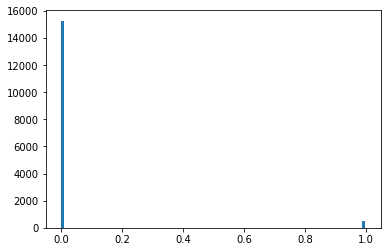

In [75]:
plt.hist(gb_y_pred_proba[:,1], bins = 100)

In [49]:
gb_y_pred_proba[fp_index_list]

array([[0.22037985, 0.77962015],
       [0.14426907, 0.85573093],
       [0.02985219, 0.97014781],
       [0.05609168, 0.94390832],
       [0.02985219, 0.97014781]])

In [50]:
gb_y_pred_proba[fn_index_list]

array([[0.88454965, 0.11545035],
       [0.84782311, 0.15217689]])

Text(0.5,0,'Average contribution to information gain')

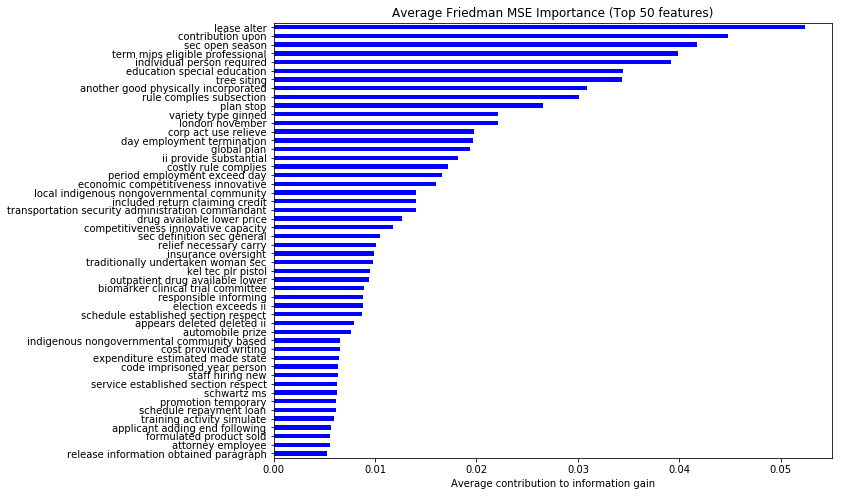

In [54]:
# Plot the feature importance
feat_scores = pd.Series(gb.feature_importances_,
                           index=vocab)

feat_scores = feat_scores.sort_values()[::-1][:50][::-1]
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Friedman MSE Importance (Top 50 features)')
ax.set_xlabel('Average contribution to information gain')

In [56]:
in_progress.shape

(3, 24)

In [64]:
# Get input of bill still in progress
input_corpus = process_corpus(in_progress, 'body')

input_vec = tfvect.transform(input_corpus)
input_y_pred = gb.predict(input_vec)
input_y_pred_proba = gb.predict_proba(input_vec)


------------------
Step 1 of 4: Creating corpus...
------------------
Step 2 of 4: Tokenizing...
------------------
Step 3 of 4: Stripping out stop words, punctuation, and numbers...
------------------
Step 4 of 4: Lemmatizing...
------------------
NLP preprocessing complete ...


In [65]:
input_y_pred_proba

array([[9.99862783e-01, 1.37217337e-04],
       [9.99862783e-01, 1.37217337e-04],
       [9.99780940e-01, 2.19060479e-04]])